In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
import keras.backend as K
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc, fbeta_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn
import time
import pickle
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('../../machine_learning/cloud_functions/data.csv')
df = pd.DataFrame(data)

attack_IDs = []

for _, row in df.iterrows():
    dimension = int(row['attack'].split('_')[0].replace('p',''))

    if row['attack'] in ['1080p', '720p', '480p', '360p', '240p', '144p']:
            attack_IDs.append(1)
    else:
        attack_IDs.append(0)

df['attack_ID'] = attack_IDs

df = df.drop(['Unnamed: 0',
              'attack',
              'title',
              'path',
              'kind',
             'temporal_canny-series',
             'temporal_cross_correlation-series',
             'temporal_difference-series',
             'temporal_histogram_distance-series', 
             'temporal_dct-series', 
        ],axis=1)
df=df.dropna(axis=1)
print('Number of attacks:',df[df['attack_ID']==0].shape)
print('Number of legit renditions:',df[df['attack_ID']==1].shape)

Number of attacks: (10856, 29)
Number of legit renditions: (1795, 29)


# Data Visualization

In [3]:
df.head(25)

,dimension,fps,size,temporal_canny-euclidean,temporal_canny-manhattan,temporal_canny-max,temporal_canny-mean,temporal_canny-std,temporal_cross_correlation-euclidean,temporal_cross_correlation-manhattan,temporal_cross_correlation-max,temporal_cross_correlation-mean,temporal_cross_correlation-std,temporal_dct-euclidean,temporal_dct-manhattan,temporal_dct-max,temporal_dct-mean,temporal_dct-std,temporal_difference-euclidean,temporal_difference-manhattan,temporal_difference-max,temporal_difference-mean,temporal_difference-std,temporal_histogram_distance-euclidean,temporal_histogram_distance-manhattan,temporal_histogram_distance-max,temporal_histogram_distance-mean,temporal_histogram_distance-std,attack_ID
0,1080,29,5264133,0.116133,7.003040,0.056071,0.007454,0.007856,0.050605,2.112032,0.997725,0.995422,0.001143,35.444673,0.002651,3.979553,3.288968,0.327497,0.081874,4.081940,0.722792,0.606267,0.049689,3.340637,0.028868,0.385370,0.309919,0.031505,0
1,1080,29,1194152,0.161292,3.014967,0.053765,0.011580,0.009598,0.010995,1.125966,0.999615,0.999027,0.000324,4.873064,0.020890,0.736389,0.424953,0.160961,0.439884,0.463156,0.898736,0.595829,0.068722,0.366303,0.394302,0.062149,0.030749,0.014875,0
2,1080,29,5978909,2.058963,0.047738,0.274441,0.190849,0.020989,5.998315,0.015925,0.623170,0.445279,0.071778,465.186561,0.000201,48.228378,43.349308,1.601207,0.032775,1.327428,0.723090,0.612284,0.048098,0.046587,1.976843,0.006103,0.004297,0.000639,0
3,1080,29,5526314,0.118175,30.567164,0.041260,0.008411,0.007120,0.096844,26.073278,0.991337,0.990971,0.000167,140.295996,0.000667,15.382782,13.053813,0.868439,0.062225,1.705640,0.725071,0.611129,0.048088,3.906239,0.024558,0.466188,0.362786,0.032724,0
4,1080,29,4815850,0.467668,0.267728,0.080973,0.041175,0.014369,0.097822,24.431297,0.993808,0.990948,0.001131,10.028362,0.009408,1.075564,0.932931,0.064381,0.062755,2.179239,0.727376,0.608700,0.047083,0.236711,0.651023,0.024057,0.022053,0.000959,0
5,144,29,128627,0.183766,2.179883,0.075873,0.012685,0.011522,0.035328,1.568010,0.997962,0.996850,0.000964,6.531636,0.014962,1.037519,0.589863,0.151784,0.432024,0.563119,0.741618,0.603233,0.073824,0.368645,0.349116,0.055327,0.033603,0.007249,1
6,144,29,144106,0.331097,0.545818,0.099826,0.024627,0.018622,0.079957,6.031550,0.995540,0.992746,0.001724,36.545058,0.002574,4.485832,3.386981,0.376510,0.487738,0.439931,0.741455,0.597782,0.078238,3.351312,0.028769,0.387685,0.310950,0.031202,0
7,144,29,36763,0.180061,2.552909,0.074761,0.012102,0.011639,0.099502,159.997864,0.994674,0.991250,0.003087,11.856751,0.008234,2.209846,1.064820,0.297684,1.920128,0.063668,0.866428,0.494936,0.166658,1.316163,0.080847,0.200074,0.116252,0.039354,0
8,144,29,153315,1.780944,0.055559,0.244141,0.165207,0.016944,5.917802,0.016149,0.630108,0.452845,0.071742,458.401405,0.000204,47.418232,42.716138,1.601559,0.439507,0.497833,0.747206,0.609469,0.075831,0.481177,0.245913,0.066154,0.044056,0.008506,0
9,144,29,142237,0.159926,3.734954,0.067193,0.011024,0.010044,0.133683,2.332032,0.989161,0.987576,0.001018,141.154432,0.000663,15.712341,13.128998,0.941583,0.434637,0.472494,0.736627,0.603941,0.076141,4.110569,0.023317,0.515025,0.381627,0.035906,0


In [4]:
df.describe()

,dimension,fps,size,temporal_canny-euclidean,temporal_canny-manhattan,temporal_canny-max,temporal_canny-mean,temporal_canny-std,temporal_cross_correlation-euclidean,temporal_cross_correlation-manhattan,temporal_cross_correlation-max,temporal_cross_correlation-mean,temporal_cross_correlation-std,temporal_dct-euclidean,temporal_dct-manhattan,temporal_dct-max,temporal_dct-mean,temporal_dct-std,temporal_difference-euclidean,temporal_difference-manhattan,temporal_difference-max,temporal_difference-mean,temporal_difference-std,temporal_histogram_distance-euclidean,temporal_histogram_distance-manhattan,temporal_histogram_distance-max,temporal_histogram_distance-mean,temporal_histogram_distance-std,attack_ID
count,12651.000000,12651.000000,1.265100e+04,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,1.265100e+04,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000,12651.000000
mean,487.745791,27.248202,1.248156e+06,1.749368,4.204301,0.319929,0.148508,0.063421,0.643549,4.183038,0.955891,0.940320,1.067621e-02,111.153262,0.027510,13.459245,10.473448,1.496951,0.759191,5.346783,0.794304,0.497151,0.126987,3.960345,3.683325,0.483743,0.371976,0.054772,0.141886
std,305.021518,3.154727,1.642108e+06,1.989219,117.544660,0.275006,0.184925,0.068815,1.322162,55.837374,0.102643,0.124887,2.962763e-02,136.020064,0.285897,16.372004,12.875918,2.856446,0.616399,332.901670,0.218077,0.256441,0.076143,6.620540,117.884751,0.756532,0.628657,0.109420,0.348947
min,144.000000,6.000000,9.585000e+03,0.009380,0.008852,0.003852,0.000460,0.000758,0.000006,0.010145,0.058852,0.046452,7.339043e-08,0.041064,0.000093,0.009061,0.006551,0.000179,0.002622,0.017690,0.000380,0.000094,0.000107,0.000040,0.001951,0.000021,0.000003,0.000001,0.000000
25%,240.000000,25.000000,2.050245e+05,0.254075,0.044686,0.083428,0.016451,0.015031,0.028997,0.451702,0.977554,0.970746,3.753653e-04,5.840990,0.000501,0.968871,0.519569,0.080606,0.319636,0.143689,0.679443,0.276505,0.072112,0.181914,0.020351,0.028815,0.016616,0.003228,0.000000
50%,360.000000,29.000000,6.371750e+05,0.905376,0.159051,0.224962,0.069953,0.035903,0.119257,1.078089,0.993681,0.989068,1.263111e-03,36.748396,0.002958,5.287090,3.307947,0.277546,0.593706,0.288437,0.882948,0.522599,0.107853,0.575166,0.212037,0.090123,0.052131,0.010913,0.000000
75%,720.000000,29.000000,1.493682e+06,2.620052,1.168487,0.545695,0.214933,0.090537,0.315543,1.658490,0.998841,0.997369,4.910697e-03,200.653018,0.018055,23.943819,18.637305,1.444033,1.020521,0.736786,0.971476,0.711813,0.164389,5.307770,1.108433,0.668737,0.473824,0.046076,0.000000
max,1080.000000,30.000000,1.779906e+07,10.630448,9216.000000,0.999729,0.991088,0.423156,9.487759,3869.284133,1.000000,0.999999,3.576178e-01,1125.423974,22.106306,128.047729,117.543450,26.026508,5.449329,36863.999999,1.000000,0.964685,0.465109,47.922163,11941.602058,4.951246,4.466254,0.959741,1.000000


In [5]:
df_corr = df.corr()

In [6]:
plt.figure(figsize=(10,10))
corr = df_corr.drop(['attack_ID'],axis=1).corr('spearman')
corr.style.background_gradient().set_precision(2)

,dimension,fps,size,temporal_canny-euclidean,temporal_canny-manhattan,temporal_canny-max,temporal_canny-mean,temporal_canny-std,temporal_cross_correlation-euclidean,temporal_cross_correlation-manhattan,temporal_cross_correlation-max,temporal_cross_correlation-mean,temporal_cross_correlation-std,temporal_dct-euclidean,temporal_dct-manhattan,temporal_dct-max,temporal_dct-mean,temporal_dct-std,temporal_difference-euclidean,temporal_difference-manhattan,temporal_difference-max,temporal_difference-mean,temporal_difference-std,temporal_histogram_distance-euclidean,temporal_histogram_distance-manhattan,temporal_histogram_distance-max,temporal_histogram_distance-mean,temporal_histogram_distance-std
dimension,1,-0.19,0.71,-0.04,0.24,-0.1,0.017,-0.21,0.42,-0.47,-0.46,-0.43,0.34,0.36,-0.11,0.38,0.38,0.3,-0.67,0.28,0.079,0.36,-0.68,0.13,0.33,0.11,0.13,0.067
fps,-0.19,1,-0.17,0.42,-0.27,0.42,0.36,0.37,0.16,0.0059,-0.19,-0.14,-0.068,0.26,-0.44,0.12,0.23,-0.078,0.33,-0.052,-0.5,-0.36,-0.18,0.12,-0.1,0.011,0.1,-0.15
size,0.71,-0.17,1,-0.32,0.43,-0.37,-0.28,-0.42,0.26,-0.38,-0.24,-0.26,0.41,0.52,-0.32,0.6,0.53,0.63,-0.74,0.13,0.53,0.79,-0.52,0.37,0.23,0.38,0.37,0.45
temporal_canny-euclidean,-0.04,0.42,-0.32,1,-0.81,0.99,0.99,0.93,0.73,-0.56,-0.75,-0.73,0.5,0.39,-0.32,0.29,0.37,0.21,0.1,0.59,-0.64,-0.67,0.13,-0.41,0.49,-0.46,-0.43,-0.49
temporal_canny-manhattan,0.24,-0.27,0.43,-0.81,1,-0.83,-0.79,-0.84,-0.58,0.39,0.55,0.57,-0.45,-0.027,-0.0034,0.0015,-0.015,-0.032,-0.11,-0.61,0.55,0.67,-0.4,0.64,-0.43,0.68,0.66,0.64
temporal_canny-max,-0.1,0.42,-0.37,0.99,-0.83,1,0.97,0.95,0.68,-0.51,-0.7,-0.68,0.49,0.33,-0.28,0.24,0.31,0.18,0.17,0.56,-0.63,-0.71,0.2,-0.42,0.44,-0.46,-0.44,-0.47
temporal_canny-mean,0.017,0.36,-0.28,0.99,-0.79,0.97,1,0.91,0.77,-0.61,-0.8,-0.78,0.55,0.43,-0.3,0.34,0.42,0.26,0.018,0.63,-0.62,-0.63,0.14,-0.42,0.56,-0.47,-0.44,-0.48
temporal_canny-std,-0.21,0.37,-0.42,0.93,-0.84,0.95,0.91,1,0.57,-0.37,-0.58,-0.57,0.41,0.31,-0.34,0.22,0.29,0.19,0.3,0.51,-0.53,-0.65,0.37,-0.31,0.33,-0.36,-0.35,-0.35
temporal_cross_correlation-euclidean,0.42,0.16,0.26,0.73,-0.58,0.68,0.77,0.57,1,-0.84,-0.98,-1,0.88,0.58,-0.35,0.58,0.58,0.57,-0.51,0.79,-0.25,-0.13,-0.12,-0.36,0.76,-0.39,-0.36,-0.35
temporal_cross_correlation-manhattan,-0.47,0.0059,-0.38,-0.56,0.39,-0.51,-0.61,-0.37,-0.84,1,0.84,0.86,-0.76,-0.56,0.17,-0.57,-0.56,-0.54,0.66,-0.67,0.17,0.012,0.18,0.33,-0.82,0.34,0.33,0.3


<Figure size 720x720 with 0 Axes>

# Define input data

We choose the input of our models (we try to make balanced dataset)

In [7]:
int(df.shape[0]*0.8)

10120

In [8]:
# Define training set as 80% of total specimens
num_train = int(df.shape[0]*0.8)

df_train_all = df[0:num_train]
df_test_all = df[num_train:]
print('We have {} train specimens and {} test specimens'.format(len(df_train_all), len(df_test_all)))

# Balance the training dataset by limiting the number of negative specimens to resemble what we have of positive
df_train_1 = df_train_all[df_train_all['attack_ID'] == 1]
df_train_0 = df_train_all[df_train_all['attack_ID'] == 0]

print('We have {} positive training specimens and {} negative training specimens'.format(len(df_train_1), len(df_train_0)))
# Take a sample from the training positives and build the final training set
df_sample_train = df_train_0.sample(df_train_1.shape[0])
df_train = df_train_1.append(df_sample_train)
df_train = df_train.sample(frac=1)
print('Balanced training set established with shape {}'.format(df_train.shape))

X_test_all = df_test_all.drop(['attack_ID'],axis=1)
df_test_1 = df_test_all[df_test_all['attack_ID'] == 1]
df_test_0 = df_test_all[df_test_all['attack_ID'] == 0]

print('We have {} positive testing specimens and {} negative testing specimens'.format(len(df_test_1), len(df_test_0)))
# Get another sample from the testing positives and build the final test set
df_sample_test = df_test_0.sample(df_test_0.shape[0])
df_test = df_test_1.append(df_sample_test)
df_test = df_test.sample(frac=1)
print('Balanced test set established with shape {}'.format(df_train.shape))

df_test_0_only = df_test_0.sample(100)

y_test_all = df_test_all['attack_ID']
y_test_all = np.asarray(y_test_all)

X_train = df_train.drop(['attack_ID'],axis=1)
X_train = np.asarray(X_train)

X_test = df_test.drop(['attack_ID'],axis=1)
X_test = np.asarray(X_test)

y_train = df_train['attack_ID']
y_train = np.asarray(y_train)

y_test = df_test['attack_ID']
y_test = np.asarray(y_test)

X_test_0 = df_test_0_only.drop(['attack_ID'], axis=1)
y_test_0 = df_test_0_only['attack_ID']
X_test_0 = np.asarray(X_test_0)
y_test_0 = np.asanyarray(y_test_0)



We have 10120 train specimens and 2531 test specimens
We have 1435 positive training specimens and 8685 negative training specimens
Balanced training set established with shape (2870, 29)
We have 360 positive testing specimens and 2171 negative testing specimens
Balanced test set established with shape (2870, 29)


First we define a model where we take all variables :

In [9]:
print('TRAIN:', X_train.shape)
print('TEST:', X_test.shape)
print(df_train.columns)

TRAIN: (2870, 28)
TEST: (2531, 28)
Index(['dimension', 'fps', 'size', 'temporal_canny-euclidean',
       'temporal_canny-manhattan', 'temporal_canny-max', 'temporal_canny-mean',
       'temporal_canny-std', 'temporal_cross_correlation-euclidean',
       'temporal_cross_correlation-manhattan',
       'temporal_cross_correlation-max', 'temporal_cross_correlation-mean',
       'temporal_cross_correlation-std', 'temporal_dct-euclidean',
       'temporal_dct-manhattan', 'temporal_dct-max', 'temporal_dct-mean',
       'temporal_dct-std', 'temporal_difference-euclidean',
       'temporal_difference-manhattan', 'temporal_difference-max',
       'temporal_difference-mean', 'temporal_difference-std',
       'temporal_histogram_distance-euclidean',
       'temporal_histogram_distance-manhattan',
       'temporal_histogram_distance-max', 'temporal_histogram_distance-mean',
       'temporal_histogram_distance-std', 'attack_ID'],
      dtype='object')


Then we can normalize input data to facilitate model convergence

scaling = MinMaxScaler().fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)
df_scale = pd.DataFrame(X_train)
display(df_scale.describe())

# Define models
We will explore results with different ML techniques

## Keras neural network

In [10]:
def model():
    global network_history
    model = Sequential()
    model.add(Dense(64,input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(128, kernel_initializer='glorot_uniform', activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(256, kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(256, kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(256, kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(128, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(128,kernel_initializer= "uniform", bias_initializer="zeros",activation= "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(16,kernel_initializer= "uniform", bias_initializer="zeros",activation= "sigmoid"))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.0001), metrics=['accuracy'])
    
    network_history = model.fit(X_train, y_train, batch_size=128, epochs=500, verbose=0)
    return model

NN_model = model()
print(NN_model.metrics_names)

NN_model.evaluate(X_test, y_test)

# Save the weights
NN_model.save_weights('../output/models/NN_model_weights.h5')

# Save the model architecture
with open('../output/models/model_architecture.json', 'w') as f:
    f.write(NN_model.to_json())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
['loss', 'acc']
2531/2531 [==============================] - 0s 62us/step


visualization loss and accuracy

In [11]:
def plot_history(network_history,title='Loss and accuracy (Keras model)'):
    plt.figure(figsize=(15,10))
    plt.subplot(211)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    #plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.subplot(212)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    #plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

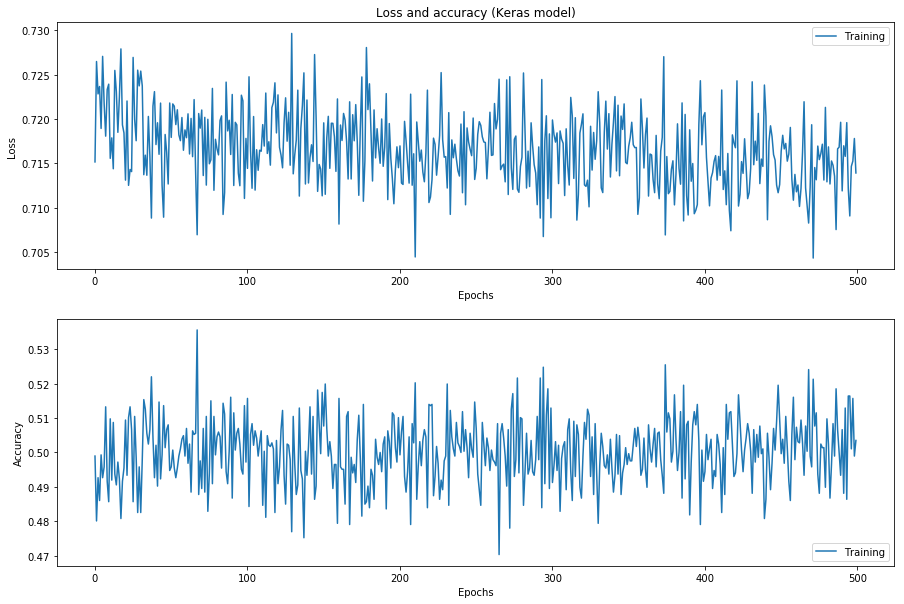

In [12]:
plot_history(network_history)

In [13]:
def plot_roc(fpr, tpr, title):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(title))
    plt.legend(loc="lower right")
    plt.show()

In [14]:
prediction = NN_model.predict(X_test)
display(pd.DataFrame(prediction))

,0
0,0.506451
1,0.506451
2,0.506451
3,0.506451
4,0.506451
5,0.506451
6,0.506451
7,0.506451
8,0.506451
9,0.506451


In [15]:
prediction_bin = prediction > 0.5
prediction_bin = prediction_bin.astype(int)
confusion_matrix(y_test, prediction.astype(int))

array([[2171,    0],
       [ 360,    0]])

TNR=0.0, TPR=1.0, F20=0.0


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


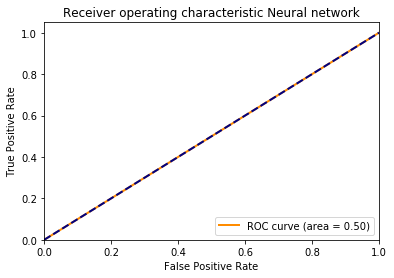

In [16]:
fpr, tpr, _ = roc_curve(y_test, prediction.astype(int))
fb = fbeta_score(y_test, prediction.astype(int), beta=20, pos_label=1) 
print('TNR={}, TPR={}, F20={}'.format(1-fpr[1],tpr[1], fb))
plot_roc(fpr, tpr, 'Neural network')

Test only with Class : 0

In [17]:
NN_model.evaluate(X_test_0, y_test_0)

100/100 [==============================] - 0s 65us/step


[0.7061333656311035, 0.0]

In [18]:
prediction_0 = NN_model.predict(X_test_0)
prediction_0_bin = prediction_0 > 0.5
prediction_0_bin = prediction_0_bin.astype(int)
confusion_matrix(y_test_0, prediction_0_bin)

array([[  0, 100],
       [  0,   0]])

In [19]:
NN_model.evaluate(X_test_all,y_test_all)

2531/2531 [==============================] - 0s 37us/step


[0.7024628257902183, 0.14223627024891347]

In [20]:
prediction_NN = NN_model.predict(X_test)
prediction_NN_train = NN_model.predict(X_train)

In [21]:
prediction_NN_all_bin = prediction_NN > 0.5
prediction_NN_all_bin = prediction_NN_all_bin.astype(int)
confusion_matrix(y_test_all, prediction_NN_all_bin)

array([[   0, 2171],
       [   0,  360]])

TNR=0.0, TPR=1.0, F20=0.9851840224935339


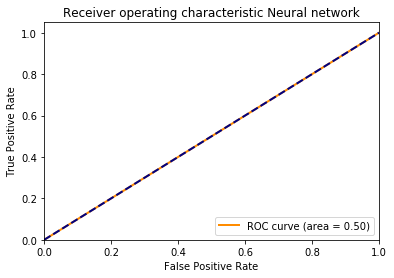

In [22]:
fpr, tpr, _ = roc_curve(y_test_all, prediction_NN_all_bin)
fb = fbeta_score(y_test_all, prediction_NN_all_bin, beta=20, pos_label=1) 
print('TNR={}, TPR={}, F20={}'.format(1-fpr[1],tpr[1], fb))
plot_roc(fpr, tpr, 'Neural network')

# Random forest with scikit-learn

In [23]:
random_forest = RandomForestClassifier(n_estimators=15,)
random_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
random_forest.score(X_test,y_test)

0.916633741604109

In [25]:
prediction_RF = random_forest.predict(X_test)

In [26]:
confusion_matrix(y_test, prediction_RF)

array([[1980,  191],
       [  20,  340]])

In [27]:
random_forest.score(X_test_0,y_test_0)

0.92

In [28]:
prediction_RF_0 = random_forest.predict(X_test_0)
confusion_matrix(y_test_0,prediction_RF_0)

array([[92,  8],
       [ 0,  0]])

In [29]:
random_forest.score(X_test_all,y_test_all)

0.916633741604109

In [30]:
prediction_RF_all = random_forest.predict(X_test_all)
confusion_matrix(y_test_all, prediction_RF_all)

array([[1980,  191],
       [  20,  340]])

TNR=0.9120221096269, TPR=0.9444444444444444, F20=0.22750828541973697


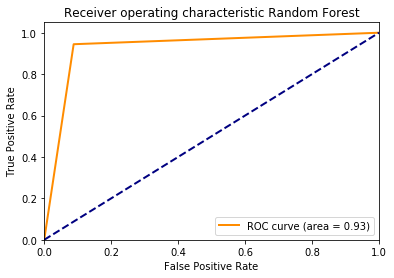

In [31]:
fpr, tpr, _ = roc_curve(y_test, prediction_RF)
fb = fbeta_score(y_test_all, prediction_RF, beta=20, pos_label=1) 
print('TNR={}, TPR={}, F20={}'.format(1-fpr[1],tpr[1], fb))
plot_roc(fpr, tpr, 'Random Forest')

### Export model to use in CLI

In [32]:
# save model to file
pickle.dump(random_forest, open("../output/models/random_forest.pickle.dat", "wb"))

# AdaBoost with scikit-learn

In [33]:
AdaBoost = AdaBoostClassifier(learning_rate=0.1)
AdaBoost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)

In [34]:
AdaBoost.score(X_test, y_test)

0.8692216515211378

In [35]:
prediction_AdaBoost = AdaBoost.predict(X_test)

In [36]:
confusion_matrix(y_test, prediction_AdaBoost)

array([[1857,  314],
       [  17,  343]])

In [37]:
AdaBoost.score(X_test_0,y_test_0)

0.84

In [38]:
prediction_AdaBoost_0 = AdaBoost.predict(X_test_0)
confusion_matrix(y_test_0,prediction_AdaBoost_0)

array([[84, 16],
       [ 0,  0]])

In [39]:
AdaBoost.score(X_test_all,y_test_all)

0.8692216515211378

In [40]:
prediction_AdaBoost_all = AdaBoost.predict(X_test_all)
confusion_matrix(y_test_all, prediction_AdaBoost_all)

array([[1857,  314],
       [  17,  343]])

TNR=0.855366190695532, TPR=0.9527777777777777, F20=0.9508215986782528


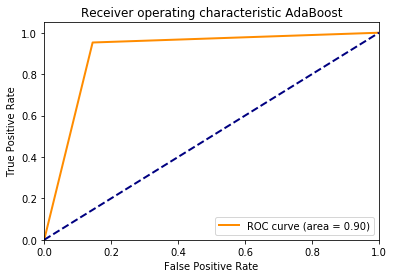

In [41]:
fpr, tpr, _ = roc_curve(y_test, prediction_AdaBoost)
fb = fbeta_score(y_test, prediction_AdaBoost, beta=20,pos_label=1) 
print('TNR={}, TPR={}, F20={}'.format(1-fpr[1],tpr[1], fb))
plot_roc(fpr, tpr, 'AdaBoost')

In [42]:
print(AdaBoost)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)


### Export model to use in CLI

In [43]:
# save model to file
pickle.dump(AdaBoost, open("../output/models/AdaBoost.pickle.dat", "wb"))

# SVM with scikit-learn

In [61]:
scaling = MinMaxScaler().fit(X_train) 
X_train_scaled = scaling.transform(X_train) 
X_test_scaled = scaling.transform(X_test) 
df_scale = pd.DataFrame(X_train_scaled) 
display(df_scale.describe())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
count,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000
mean,0.324605,0.893075,0.091023,0.158103,0.001005,0.306037,0.142698,0.156651,0.040760,0.002137,0.965378,0.960042,0.023250,0.058782,0.005169,0.062538,0.052758,0.034918,0.158658,0.004181,0.796287,0.514480,0.270597,0.052175,0.001027,0.062848,0.052220,0.041807
std,0.293400,0.114367,0.116566,0.192867,0.020232,0.270614,0.190477,0.171671,0.110736,0.020754,0.107619,0.111260,0.084540,0.108043,0.028127,0.111531,0.098200,0.089055,0.129733,0.033337,0.209018,0.271237,0.160807,0.113222,0.019213,0.125830,0.114597,0.103645
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.102564,0.791667,0.015911,0.018232,0.000007,0.069116,0.011941,0.033132,0.001046,0.000686,0.985935,0.980156,0.000644,0.001614,0.000098,0.002541,0.001395,0.001420,0.064836,0.000309,0.674961,0.278258,0.157198,0.002079,0.000022,0.003543,0.001949,0.002680
50%,0.230769,0.958333,0.050120,0.066190,0.000043,0.204951,0.050906,0.090118,0.004260,0.000756,0.997645,0.995869,0.002211,0.004687,0.001738,0.007228,0.004076,0.003937,0.123962,0.000668,0.873944,0.543579,0.230290,0.006440,0.000124,0.010017,0.006109,0.007860
75%,0.615385,0.958333,0.116088,0.233560,0.000279,0.529933,0.209149,0.230690,0.020292,0.001069,0.999511,0.998998,0.008022,0.078311,0.005146,0.084279,0.068894,0.016242,0.216910,0.001953,0.969965,0.748543,0.344788,0.024899,0.000409,0.038621,0.024741,0.026397
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
classifier = svm.SVC(kernel='rbf')
classifier.fit(X_train_scaled, y_train)
prediction_SVM = classifier.predict(X_test_scaled)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [64]:
classifier.score(X_test_scaled,y_test)

0.6661398656657448

In [65]:
confusion_matrix(y_test, prediction_SVM)

array([[1327,  844],
       [   1,  359]])

In [66]:
classifier.score(X_test_0,y_test_0)

1.0

In [67]:
prediction_SVM_0 = classifier.predict(X_test_0)
confusion_matrix(y_test_0,prediction_SVM_0)

array([[100]])

In [68]:
classifier.score(X_test_all,y_test_all)

0.8577637297510865

In [69]:
prediction_SVM_all = classifier.predict(X_test_all)
confusion_matrix(y_test_all, prediction_SVM_all)

array([[2171,    0],
       [ 360,    0]])

TNR=0.6112390603408567, TPR=0.9972222222222222, F20=0.9914326838977155


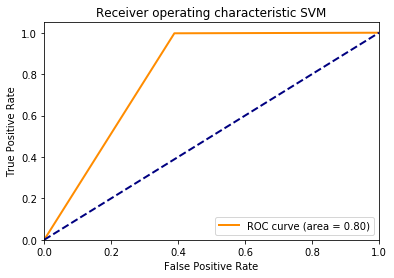

In [70]:
fpr, tpr, _ = roc_curve(y_test, prediction_SVM)
fb = fbeta_score(y_test, prediction_SVM, beta=20, pos_label=1) 
print('TNR={}, TPR={}, F20={}'.format(1-fpr[1],tpr[1], fb))
plot_roc(fpr, tpr, 'SVM')

# XGBoost

In [71]:
XGBoost = xgb.XGBClassifier()
XGBoost.fit(X_train_scaled, y_train)
prediction_XGB = XGBoost.predict(X_test_scaled)

In [72]:
XGBoost.score(X_test_scaled,y_test)

0.9549585144211774

In [73]:
confusion_matrix(y_test, prediction_XGB)

array([[2078,   93],
       [  21,  339]])

In [74]:
XGBoost.score(X_test_0,y_test_0)

1.0

In [75]:
start_time = time.time()
prediction_XGB_0 = XGBoost.predict(X_test_0)
elapsed_time = time.time() - start_time

confusion_matrix(y_test_0,prediction_XGB_0)

print('Prediction time:', elapsed_time)

Prediction time: 0.001069784164428711


In [77]:
XGBoost.score(X_test_scaled,y_test)

0.9549585144211774

In [78]:
confusion_matrix(y_test, prediction_XGB)

array([[2078,   93],
       [  21,  339]])

TNR=0.9571625978811608, TPR=0.9416666666666667, F20=0.9411972416085078


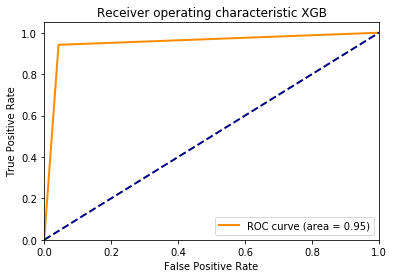

In [79]:
fpr, tpr, _ = roc_curve(y_test, prediction_XGB)
fb = fbeta_score(y_test, prediction_XGB, beta=20, pos_label=1) 
print('TNR={}, TPR={}, F20={}'.format(1-fpr[1],tpr[1], fb))
plot_roc(fpr, tpr, 'XGB')

### Export model to use in CLI

In [60]:
# save model to file
pickle.dump(XGBoost, open("../output/models/XGBoost.pickle.dat", "wb"))